# Super Resolution - Keras

http://arxiv.org/abs/1603.08155

In this notebook, we will explore how we can train a convolution network to enhance the quality of an image.

## Imports

In [6]:
from __future__ import division,print_function
from PIL import Image
import gc,re

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Activation, merge, Conv2DTranspose, Lambda, Add
#from keras.layers.merge import Add
from keras.optimizers import Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

from importlib import reload
from keras import backend as K
from keras.datasets import imdb

np.random.seed(7)

from keras.preprocessing.image import load_img, img_to_array

import bcolz
from IPython.display import FileLink
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

from scipy.optimize import fmin_l_bfgs_b
from keras import metrics
from scipy.misc import imsave
import imageio

%matplotlib inline

The data was obtained from http://files.fast.ai/data/.

It consists of imagenet data which has been resized to 72x72 and 288x288.

## Build Super Resolution Network

In [7]:
PATH = 'data/super_resolution/'
LOW_RES_PATH = PATH + 'trn_resized_72.bc'
HIGH_RES_PATH = PATH + 'trn_resized_288.bc'

In [9]:
arr_lr = bcolz.open(LOW_RES_PATH)[:]
arr_hr = bcolz.open(HIGH_RES_PATH)[:]

In [10]:
arr_lr.shape, arr_hr.shape

((19439, 72, 72, 3), (19439, 288, 288, 3))

As we can see, we almost 20000 images of two different resolutions.

In [11]:
sample_lr_img = arr_lr[10]
sample_hr_img = arr_hr[10]

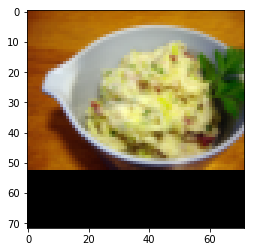

In [12]:
plt.imshow(sample_lr_img.astype('uint8'));plt.show()

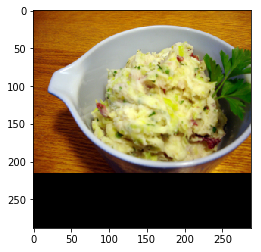

In [13]:
plt.imshow(sample_hr_img.astype('uint8'));plt.show()

### Create Super Res Model ( a.k.a Image Transform Net) Architecture

The paper on super resolution linked above describes the following architecture which was used by them to improve the resolution of an image. We will be building the X4 super-resolution network.

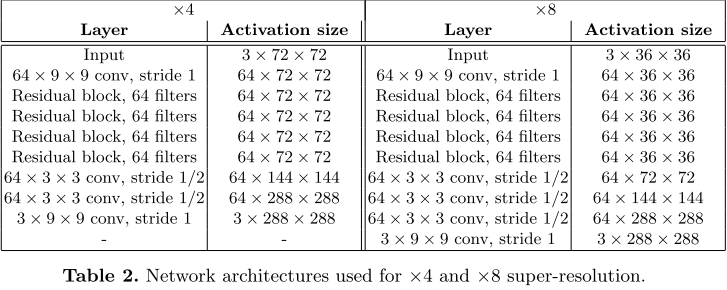

In [14]:
Image.open(PATH+'sr.png')

In [15]:
def convolution_block(inp, n_filters, kernel_size, strides, padding='same', add_activation = True):
    x = Convolution2D(filters=n_filters, kernel_size=kernel_size, strides=strides, padding=padding)(inp)
    x = BatchNormalization()(x)
    if add_activation:
        x = Activation('relu')(x)
    return x

The architecture above uses 4 residual blocks. Here is what a single residual/resnet block looks like. (Note these residual blocks are part of the ResNet architecture for image classification)

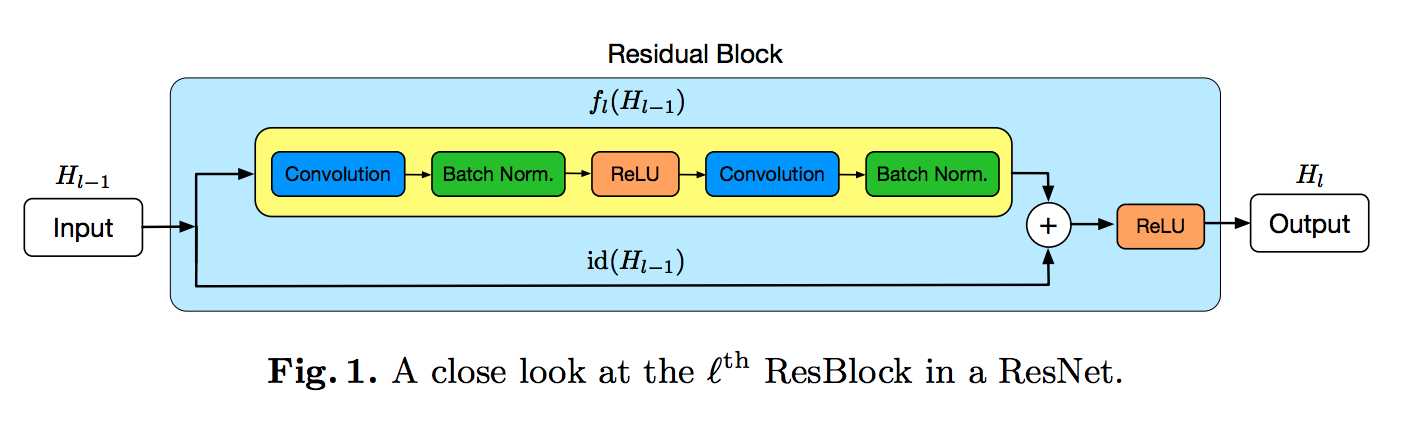

In [16]:
Image.open(PATH+'resnet_block.png')

In [17]:
#resnet block is also called the residual block
def resnet_block(inp, n_filters=64):
    x = convolution_block(inp=inp,n_filters=n_filters, kernel_size=(3,3), strides=(1,1), add_activation=True)
    x = convolution_block(x, n_filters, (3,3), (1,1), add_activation=False)
    x = Add()([x, inp])
    return x
    

In [18]:
def deconvolution_block(inp, n_filters, kernel_size, strides=(2,2), padding='same'):
    x = Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, strides=strides,\
                        padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

Now we can use the functions above to build the exact same architecture used by the paper. 

* The Conv2DTranspose is nothing but a Transposed Convolution Layer (also called Deconvolution or Fractionally Strided Convolution). The purpose of this layer is to "undo" the convolution function. It does this by padding the smaller image in such as way that on applying filters to it, we get a larger image. In our case, since we have used strides of (2,2), we will essentially be doubling the size of the image.


* Note we have a lambda layer at the very end because the penultimate layer uses an activation of 'tanh'. This brings the output of that layer between -1 and 1. For VGG the images are in the range 0 to 255. To convert the tanh range to an acceptable VGG range, we have used a Lambda layer.

In [19]:
inp = Input(arr_lr.shape[1:])
x = convolution_block(inp, n_filters=64, kernel_size=(9,9), strides=(1,1))
for i in range(0,4):
    x = resnet_block(x, n_filters=64)
for i in range(0,2):
    x = deconvolution_block(x, n_filters=64,kernel_size=(3,3), strides=(2,2))
x = Convolution2D(filters=3, kernel_size=(9,9), padding='same', activation='tanh')(x)
outp = Lambda(lambda x : (x+1)*127.5)(x)

Now first of all, let us understand what we need to do. We need to take an input image with low resolution and then convert that image into one with high resolution.

**Task**
What we will be doing is training an 'Image Transform Net' which is nothing but the CNN model which he had just built above. We want this model to convert a low res image into a high res image.

Now in the image below, instead of 'Style Target' , consider that to be 'High Res Actual' and the 'Content Target' is nothing but the output of our Image Transform Net, i.e. 'High Res Created'.

**What is the use of VGG here?**

We will be using the VGG network as our loss function (similar to how we used that for style transfer). The idea behind this is, we will be feeding two images to the VGG network (one actual high res and one high res created by our model) and then compare their outputs at one or more conv layers. 

The key is to train our Image Transform Net model to produce images which minimizes the loss between the outputs f some conv layers ( this loss is called the *perceptual loss*). By reducing this loss, we will be able to train our Image Transform Net to produce images with higher resolution.

**NOTE**

Sometimes we calculate the error of a network not by comparing its output to labels immediately, but by first putting its output through a function, and comparing that new output to something we consider to be ideal. That function could be another neural network. For example, in real-time style transfer (Johnson et al.148), the network we train takes an image and transforms it into another image; we then take that generated image and analyze it with another neural network, comparing the new output with something we consider to be ideal. The point of the second neural network is to assess the error in the generated image in a deeper way than just calculating errors pixel by pixel with respect to an image we consider to be ideal. The authors of the real-time style transfer paper call this higher-level error "perceptual loss", as opposed to "per-pixel loss".

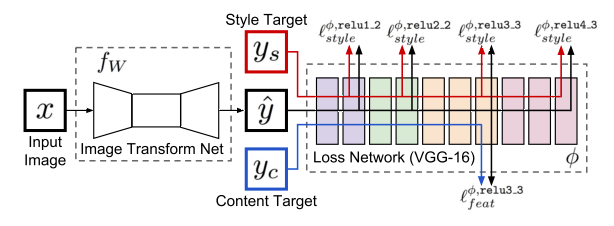

In [20]:
Image.open(PATH+'sr_method.png')

Each image fed through a VGG network was pre-processed in a certain way. We are going to do the same.

### Use VGG As Loss Function 

In [21]:
# Preprocess VGG16 inputs
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

#The input to the VGG will be a tensor of the same shape as a high resolution image
vgg_inp = Input(shape=arr_hr.shape[1:])


In [22]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

Now, VGG is just being used as our loss function. Its only use here is to take two images and then calculate the loss between them among some convolution layer outputs. 

As such, we dont want to train the VGG network itself.

In [23]:
for layer in vgg16.layers:
    layer.trainable = False

In [24]:
def get_output_layers_of_vgg(i):
    layer_name = 'block' + str(i) + '_conv2'
    return vgg16.get_layer(layer_name).output

We need to compare thee outputs among some conv layers. Here we are selecting the conv2 layers of blocks 1,2 and 3.

In [25]:
outputs = [] 
for i in [1,2,3]:
    outputs.append(get_output_layers_of_vgg(i))

vgg_content = Model(inputs=vgg_inp, outputs=outputs)

In [26]:
vgg_content.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

Now, with Keras, we can call models just like we can call layers. 

"With the functional API, it is easy to reuse trained models: you can treat any model as if it were a layer, by calling it on a tensor. Note that by calling a model you aren't just reusing the architecture of the model, you are also reusing its weights."

Reference : https://keras.io/getting-started/functional-api-guide/

Thus, in the next step, we will be using the above created model once with directly feeding it the high res image. The other time, we will be feeding this model the output of our Image Transform Net.

In [27]:
vgg_act = vgg_content(vgg_inp)
vgg_trained = vgg_content(outp)

The only step remaining now is manually creating a loss function. We will be building a RMSE loss function in the next few cell blocks.

In [28]:
def get_mean_squared_error_of_diff(diff):
    n_dims = K.ndim(diff)
    dims_list = list(range(1,n_dims))   # This returns [1,2,3] for a tensor which has 4 dimensions
    
    diff_sq = diff**2
    rmse = K.sqrt(K.mean(diff_sq, dims_list))   # We will be calculating error along each axis
    
    return K.expand_dims(rmse,0)  #need to convert back to batch size

In [29]:
layer_weights = [0.1, 0.8, 0.1] #Giving weigths to how much of loss to consider from the three layer conv outputs

def loss(x):
    total_loss = 0
    n_layers = len(layer_weights)
    
    #Now we need to calculate the loss per layer and then add them up for total loss
    
    #We are adding up the actual and created layer lists and then sending. 
    #This the 0the and 3rd elements of x corresspond to the layres of vgg_act and vgg_trained. 
    #Same goes for 1st and 4th and 2nd and 5th.
    
    for i in range(n_layers):
        total_loss = total_loss + get_mean_squared_error_of_diff(x[i] - x[i+n_layers])*layer_weights[i]
    
    return total_loss

Now that we have defined our loss function, we can created a model which will try and minimize this loss function (i.e. target of the model should be to output 0). 

The inputs to this model will be a list of low res and high res images.

In [43]:
super_res_model = Model([inp, vgg_inp], Lambda(loss)(vgg_act+vgg_trained))
targ = np.zeros((arr_hr.shape[0], 1))

In [44]:
super_res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 72, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 72, 72, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 72, 72, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

The summary gives a detailed explanation of what we have done so far. 
* Layer 'input_1' is the low res input which gets fed into our Image Transform Net model. The output of that model is Layer 'conv2d_10'. 

* After that we have the Layer 'input_2' which is nothing but our actual high res image. 

* These get get fed into the Layer/Model 'model_1' which gets the output of these two inputs. 

* This then gets fed into the layer 'lambda_7' which gets the loss between these outputs. Based on the loss output, the weights of our Image Transform Net model would get updated in such as way so as to decrease the loss to 0.

In [45]:
super_res_model.compile(optimizer='adam', loss='mse')
super_res_model.fit(x=[arr_lr, arr_hr], y=targ, batch_size=32, epochs=2)

Epoch 1/2
19439/19439 [==============================] - 2276s 117ms/step - loss: 78779.2658
Epoch 2/2
19439/19439 [==============================] - 2263s 116ms/step - loss: 49766.0910


Running one more epoch ...

In [71]:
K.set_value(super_res_model.optimizer.lr, 1e-4)
super_res_model.fit(x=[arr_lr, arr_hr], y=targ, batch_size=32, epochs=1)

Epoch 1/1
19439/19439 [==============================] - 2261s 116ms/step - loss: 48054.9525


We are only interested in the Image Tranform Net model which we just trained. That was the model which we had defined in the very beginning of our notebook. Let us also save the weights so we dont have to go through the lengthy training again.

In [30]:
top_model = Model(inp, outp)

In [73]:
top_model.save_weights(PATH+'sr_final.h5')

In [31]:
top_model.load_weights(PATH+'sr_final.h5')

In [32]:
def compare_output(x,y):
    fig = plt.figure(figsize=(12,12))
    a = fig.add_subplot(1,2,1)
    plt.imshow(x)
    z = fig.add_subplot(1,2,2)
    plt.imshow(y)

Let us now get the first 100 predictions of the model

In [76]:
p = top_model.predict(arr_lr[0:100])

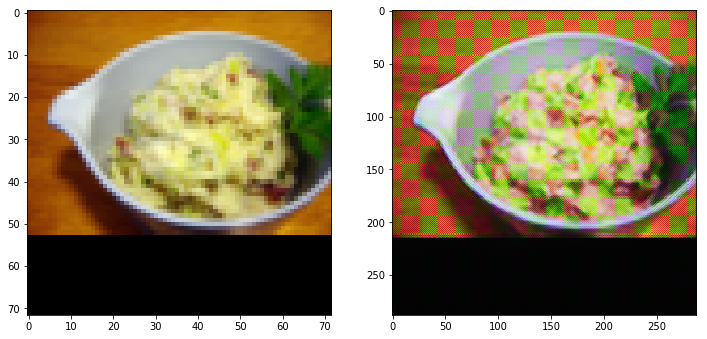

In [77]:
compare_output(arr_lr[10].astype('uint8'), p[10].astype('uint8'))

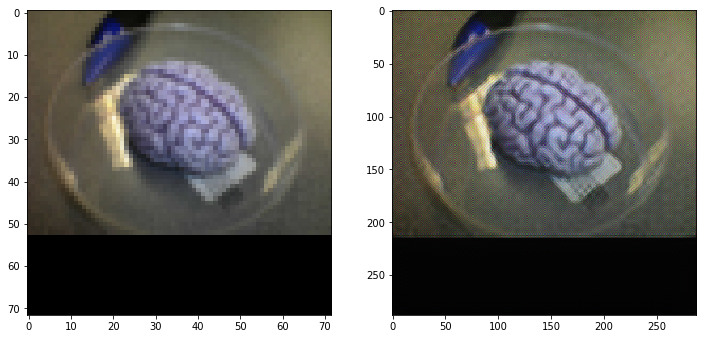

In [78]:
compare_output(arr_lr[56].astype('uint8'), p[56].astype('uint8'))

It is simply amazing how we could train a model to produce higher resolution images using a perceptual loss which we got from another image classification model!

### Fixing CheckerBoard Pattern

One thing which we can notice in the high res images which were generated by our network is that there is a distinct checkerboard pattern which becomes visible on zooming into the image.

One way to counter that is to use 'Upsampling' layers instead of DeConv (or Transposed Conv) layers. Upsampling (if used with default size = (2,2) ) replaces each element by a 2X2 matrix of that element.

Reference : https://distill.pub/2016/deconv-checkerboard/

Reference : https://keras.io/layers/convolutional/#upsampling2d

In [48]:
from keras.layers import UpSampling2D

In [51]:
def upsample_block(inp, n_filters, kernel_size):
    x = UpSampling2D()(inp)
    x = Convolution2D(filters=n_filters, kernel_size=kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [53]:
def get_upsampled_model():
    inp = Input(arr_lr.shape[1:])
    x = convolution_block(inp, n_filters=64, kernel_size=(9,9), strides=(1,1))
    for i in range(0,4):
        x = resnet_block(x, n_filters=64)
    for i in range(0,2):
        x = upsample_block(x, n_filters=64,kernel_size=(3,3))
    x = Convolution2D(filters=3, kernel_size=(9,9), padding='same', activation='tanh')(x)
    outp = Lambda(lambda x : (x+1)*127.5)(x)
    return inp,outp

In [54]:
inp, outp = get_upsampled_model()

Now that our Image Transfor Net model is using upsampling as opposed to transposed convolutions, we can go ahead and repeat the whole process again.

In [55]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [57]:
vgg_content.summary()vgg_act = vgg_content(vgg_inp)
vgg_trained = vgg_content(outp)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 288, 288, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 288, 288, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 288, 288, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 288, 288, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 144, 144, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 144, 144, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 144, 144, 128)     147584    
__________

In [58]:
vgg_inp

<tf.Tensor 'input_2:0' shape=(?, 288, 288, 3) dtype=float32>

In [59]:
vgg_act = vgg_content(vgg_inp)
vgg_trained = vgg_content(outp)

In [60]:
super_res_model = Model([inp, vgg_inp], Lambda(loss)(vgg_act+vgg_trained))
targ = np.zeros((arr_hr.shape[0], 1))

In [61]:
super_res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 72, 72, 3)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 72, 72, 64)   15616       input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 72, 72, 64)   256         conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_15 (Activation)      (None, 72, 72, 64)   0           batch_normalization_23[0][0]     
__________________________________________________________________________________________________
conv2d_22 

In [63]:
super_res_model.compile(optimizer='adam', loss='mse')
super_res_model.fit(x=[arr_lr, arr_hr], y=targ, batch_size=8, epochs=2)

Epoch 1/2
19439/19439 [==============================] - 2795s 144ms/step - loss: 53314.1258
Epoch 2/2
19439/19439 [==============================] - 2789s 143ms/step - loss: 45966.0180


In [64]:
top_model = Model(inp, outp)

In [65]:
top_model.save_weights(PATH+'sr_upsampled.h5')

In [66]:
p = top_model.predict(arr_lr[0:100])

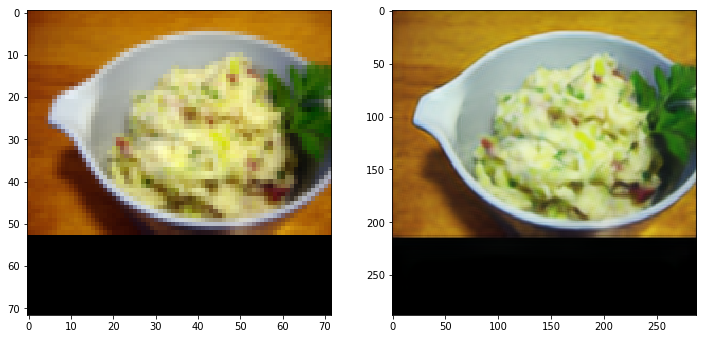

In [67]:
compare_output(arr_lr[10].astype('uint8'), p[10].astype('uint8'))

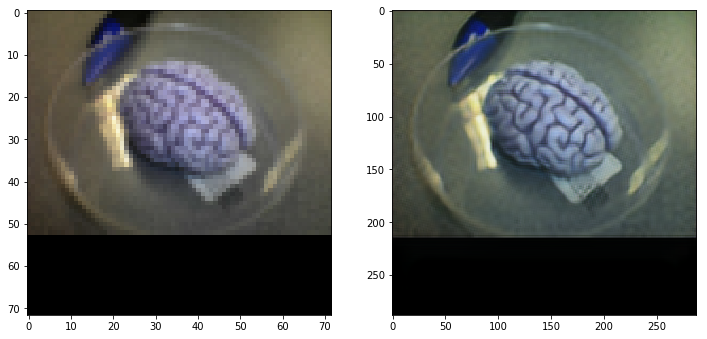

In [68]:
compare_output(arr_lr[56].astype('uint8'), p[56].astype('uint8'))

If we zoom into these images, we can see that the checkerboard patterns are almost non existent ( we can train for a few more epochs to get better results if we have time).



### Predicting with High-Res Images as Input

Let us try something else now. What if we use the same weights of the model we trained above, but instead of feeding it a low res image, we feed it a high res image.

In [69]:
inp = Input(arr_hr.shape[1:])
x = convolution_block(inp, n_filters=64, kernel_size=(9,9), strides=(1,1))
for i in range(0,4):
    x = resnet_block(x, n_filters=64)
for i in range(0,2):
    x = upsample_block(x, n_filters=64,kernel_size=(3,3))
x = Convolution2D(filters=3, kernel_size=(9,9), padding='same', activation='tanh')(x)
outp = Lambda(lambda x : (x+1)*127.5)(x)

In [70]:
top_model_hr = Model(inp,outp)

Now let us copy the weights of our previously trained model, to this new model which takes high res images as input.

In [124]:
def copy_weights(from_layers, to_layers):
    
    for from_layer,to_layer in zip(from_layers,to_layers):
        to_layer.set_weights(from_layer.get_weights())

In [72]:
copy_weights(top_model.layers,top_model_hr.layers)

In [73]:
gc.collect()

20830

In [122]:
hr_preds = top_model_hr.predict(arr_hr[657:658])

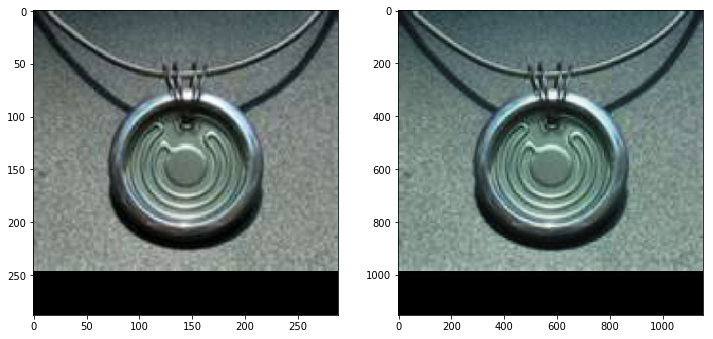

In [123]:
compare_output(arr_hr[657].astype('uint8'), hr_preds[0].astype('uint8'))

Though this might not seem like a change, I think whats left to try is train our Image Transform Net even further. That is, instead of training it on only 20000 images, we can traing it on the whole of ImageNet!
It may so happen that the model we trained can upscale the resolution regardless of the size of the input image , i.e. a model trained to upscale 72x72 images to 288x288 might as well upscale any input image of any size!